In [44]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import json

In [45]:
chrome_options = Options()
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option("useAutomationExtension", False)
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.sofascore.com/")
time.sleep(5)

groups = ['summary', 'attack', 'defence', 'passing', 'goalkeeper']

# go through 29 pages
for group in groups:
    all_results = []
    print(f"Scraping group: {group}")
    
    for page in range(1, 30):
        offset = (page - 1) * 20
        url = f"https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&offset={offset}&accumulation=total&group={group}"
        
        driver.get(url)
        time.sleep(3) 
        
        # extract JSON from source
        try:
            json_content = driver.find_element("tag name", 'pre').text
            data = json.loads(json_content)
            all_results.extend(data['results'])
            print(f"Page {page} scraped successfully.")
        except Exception as e:
            print(f"Error on page {page}: {str(e)}")
            # Save page source for debugging
            with open(f'error_page_{page}.html', 'w', encoding='utf-8') as f:
                f.write(driver.page_source)
            break

    with open(f"{group}.json", 'w', encoding='utf-8') as f:
        json.dump(all_results, f, ensure_ascii=False, indent=4)
    print(f"Saved {len(all_results)} entries to {group}.json\n")

driver.quit()

Scraping group: summary
Page 1 scraped successfully.
Page 2 scraped successfully.
Page 3 scraped successfully.
Page 4 scraped successfully.
Page 5 scraped successfully.
Page 6 scraped successfully.
Page 7 scraped successfully.
Page 8 scraped successfully.
Page 9 scraped successfully.
Page 10 scraped successfully.
Page 11 scraped successfully.
Page 12 scraped successfully.
Page 13 scraped successfully.
Page 14 scraped successfully.
Page 15 scraped successfully.
Page 16 scraped successfully.
Page 17 scraped successfully.
Page 18 scraped successfully.
Page 19 scraped successfully.
Page 20 scraped successfully.
Page 21 scraped successfully.
Page 22 scraped successfully.
Page 23 scraped successfully.
Page 24 scraped successfully.
Page 25 scraped successfully.
Page 26 scraped successfully.
Page 27 scraped successfully.
Page 28 scraped successfully.
Page 29 scraped successfully.
Saved 570 entries to summary.json

Scraping group: attack
Page 1 scraped successfully.
Page 2 scraped successfully.

In [46]:
driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.sofascore.com/")
time.sleep(5)

player_time = []
print(f"Scraping time")

for page in range(1, 30):
    offset = (page - 1) * 20
    url = f"https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=20&order=-rating&offset={offset}&accumulation=total&fields=minutesPlayed%2Cappearances%2Crating&filters=position.in.G~D~M~F"
        
    driver.get(url)
    time.sleep(3) 

    try:
        json_content = driver.find_element("tag name", 'pre').text
        data = json.loads(json_content)
        player_time.extend(data['results'])
        print(f"Page {page} scraped successfully.")
    except Exception as e:
        print(f"Error on page {page}: {str(e)}")
        # Save page source for debugging
        with open(f'error_page_{page}.html', 'w', encoding='utf-8') as f:
            f.write(driver.page_source)
        break

with open('players_time.json', 'w', encoding='utf-8') as f:
    json.dump(player_time, f, ensure_ascii=False, indent=4)

print(f"Saved {len(player_time)} entries to players_time.json.")

driver.quit()

Scraping time
Page 1 scraped successfully.
Page 2 scraped successfully.
Page 3 scraped successfully.
Page 4 scraped successfully.
Page 5 scraped successfully.
Page 6 scraped successfully.
Page 7 scraped successfully.
Page 8 scraped successfully.
Page 9 scraped successfully.
Page 10 scraped successfully.
Page 11 scraped successfully.
Page 12 scraped successfully.
Page 13 scraped successfully.
Page 14 scraped successfully.
Page 15 scraped successfully.
Page 16 scraped successfully.
Page 17 scraped successfully.
Page 18 scraped successfully.
Page 19 scraped successfully.
Page 20 scraped successfully.
Page 21 scraped successfully.
Page 22 scraped successfully.
Page 23 scraped successfully.
Page 24 scraped successfully.
Page 25 scraped successfully.
Page 26 scraped successfully.
Page 27 scraped successfully.
Page 28 scraped successfully.
Page 29 scraped successfully.
Saved 570 entries to players_time.json.


In [56]:
import csv
from collections import defaultdict
GROUP_STRUCTURE = {
    "summary": ["goals", "expectedGoals", "successfulDribbles", "tackles", 
               "assists", "accuratePassesPercentage", "rating"],
    "attack": ["goals", "expectedGoals", "bigChancesMissed", "successfulDribbles",
              "totalShots", "goalConversionPercentage", "rating"],
    "defence": ["tackles", "interceptions", "clearances", "errorLeadToGoal", "rating"],
    "passing": ["bigChancesCreated", "assists", "accuratePasses", 
                "accuratePassesPercentage", "keyPasses", "rating"],
    "goalkeeper": ["saves", "cleanSheet", "penaltySave", "savedShotsFromInsideTheBox",
                  "runsOut", "rating"],
    "players_time": ["minutesPlayed", "appearances", "rating"]
}

ordered_stats = []
seen_stats = set()
for group in GROUP_STRUCTURE.values():
    for stat in group:
        if stat == 'rating':
            continue
        if stat not in seen_stats:
            ordered_stats.append(stat)
            seen_stats.add(stat)

# CSV column order
fieldnames = ['player.name', 'player.id', 'team.name'] + ordered_stats + ['rating']

players = defaultdict(dict)

# pimport pandas as pdrocess each JSON file
for group in GROUP_STRUCTURE:
    try:
        with open(f"{group}.json", "r", encoding="utf-8") as f:
            data = json.load(f)
            
        for entry in data:
            player_id = entry["player"]["id"]
            
            for stat in GROUP_STRUCTURE[group]:
                value = entry.get(stat)
                if value is not None: 
                    players[player_id][stat] = value
                    
            # Always update name and team
            players[player_id]["player.name"] = entry["player"]["name"]
            players[player_id]["player.id"] = player_id
            players[player_id]["team.name"] = entry["team"]["name"]
            
    except FileNotFoundError:
        print(f"Warning: {group}.json not found")
        continue

sorted_players = sorted(players.values(), 
                       key=lambda x: x.get("rating", 0), 
                       reverse=True)

#write csv
with open("player_stats.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    
    for player in sorted_players:
        row = {col: player.get(col) for col in fieldnames}
        writer.writerow(row)

print("CSV file created successfully: player_stats.csv")

CSV file created successfully: player_stats.csv


In [57]:
import sqlite3

def initialize_sofascore_database():
    conn = sqlite3.connect('sofascore_player_analysis.db')
    cursor = conn.cursor()

    # create the players table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS players (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            team_name TEXT
        )
    ''')

    # creating player_statistics table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS player_statistics (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            player_id INTEGER NOT NULL,
            stat_name TEXT NOT NULL,
            stat_value REAL,
            FOREIGN KEY (player_id) REFERENCES players(id)
        )
    ''')

    conn.commit()
    conn.close()
    print("Database 'sofascore_player_analysis.db' and tables have been initialized.")


initialize_sofascore_database()

Database 'sofascore_player_analysis.db' and tables have been initialized.


In [58]:
import sqlite3
import pandas as pd

def insert_player_data_from_csv(csv_file):
    conn = sqlite3.connect('sofascore_player_analysis.db')
    cursor = conn.cursor()

    # fill missing values with 0
    df = pd.read_csv(csv_file)
    df = df.fillna(0)  
    
    for _, row in df.iterrows():
        player_id = row['player.id']
        name = row['player.name']
        team_name = row['team.name']

        # insert data into players table
        cursor.execute('''
            INSERT OR IGNORE INTO players (id, name, team_name)
            VALUES (?, ?, ?)
        ''', (player_id, name, team_name))

        #insert each stat from the row(exclude player and team info)
        for col in df.columns:
            if col in ['player.id', 'player.name', 'team.name']:
                continue

            stat_name = col
            stat_value = row[col]

            cursor.execute('''
                INSERT INTO player_statistics (player_id, stat_name, stat_value)
                VALUES (?, ?, ?)
            ''', (player_id, stat_name, stat_value))

    conn.commit()
    conn.close()
    print("Player and statistics data inserted into the database.")

# run funtion and insert data into databade
insert_player_data_from_csv("player_stats.csv")

Player and statistics data inserted into the database.


In [59]:
import sqlite3

def query_player_stats(player_name, top_n=None):
    conn = sqlite3.connect('sofascore_player_analysis.db')
    cursor = conn.cursor()

    # find id of player
    cursor.execute('SELECT id, name, team_name FROM players WHERE name = ?', (player_name,))
    result = cursor.fetchone()

    if not result:
        print(f"No player found with name '{player_name}'.")
        conn.close()
        return

    player_id, name, team = result
    print(f"\nStats for {name} ({team}):")

    # fetch all stats for the player
    cursor.execute('''
        SELECT stat_name, stat_value
        FROM player_statistics
        WHERE player_id = ?
    ''', (player_id,))
    
    stats = cursor.fetchall()
    if top_n is not None:
        stats = sorted(stats, key=lambda x: x[1], reverse=True)[:top_n]
        
    for stat_name, stat_value in stats:
        print(f"{stat_name}: {stat_value:.3f}")

    conn.close()

# example:
query_player_stats("Bukayo Saka", top_n=10)


Stats for Bukayo Saka (Arsenal):
minutesPlayed: 2933.000
accuratePasses: 1087.000
totalShots: 108.000
keyPasses: 91.000
accuratePassesPercentage: 82.980
tackles: 66.000
successfulDribbles: 49.000
appearances: 35.000
clearances: 19.000
goals: 16.000


In [60]:
import sqlite3

def clean_sofascore_database():
    conn = sqlite3.connect('sofascore_player_analysis.db')
    cursor = conn.cursor()

    # remove player_stat rows with nulll stat_name or stat_value
    cursor.execute('''
        DELETE FROM player_statistics
        WHERE stat_name IS NULL OR stat_value IS NULL
    ''')

    # remove stats where value = 0 (for specific stats only)
    cursor.execute('''
        DELETE FROM player_statistics
        WHERE stat_name IN ('goals', 'expectedGoals', 'assists') AND stat_value = 0
    ''')

    conn.commit()
    conn.close()
    print("Database cleaned of NULLs and zero-valued goal-related stats.")

In [61]:
import shutil

def backup_sofascore_database():
    source = 'sofascore_player_analysis.db'
    backup = 'sofascore_player_analysis_backup.db'
    shutil.copy(source, backup)
    print(f"Backup created: {backup}")

In [62]:
def perform_sofascore_maintenance():
    print("Starting database maintenance...")
    clean_sofascore_database()
    backup_sofascore_database()
    print("Maintenance complete.")

# run maintnance
perform_sofascore_maintenance()

Starting database maintenance...
Database cleaned of NULLs and zero-valued goal-related stats.
Backup created: sofascore_player_analysis_backup.db
Maintenance complete.


In [1]:
import pandas as pd

df = pd.read_csv('player_stats.csv')
cleaned_df = df.copy()
cleaned_df["expectedGoals"] = cleaned_df["expectedGoals"].fillna(0)
cleaned_df = cleaned_df.drop('player.id', axis=1)

print(cleaned_df.head())
print("total NaN:")
print(cleaned_df.isna().sum()) 

       player.name          team.name  goals  expectedGoals  \
0            Rodri    Manchester City      8           4.07   
1   Arijanet Murić            Burnley      0           0.00   
2  Kevin De Bruyne    Manchester City      4           2.41   
3       Phil Foden    Manchester City     19          10.34   
4  Bruno Fernandes  Manchester United     10          10.01   

   successfulDribbles  tackles  assists  accuratePassesPercentage  \
0                  42       70        9                     92.46   
1                   0        1        0                     67.49   
2                  10       14       10                     83.83   
3                  47       31        8                     89.10   
4                  19       68        8                     79.38   

   bigChancesMissed  totalShots  ...  accuratePasses  keyPasses  saves  \
0                 2          62  ...            3359         50      0   
1                 0           0  ...             355      

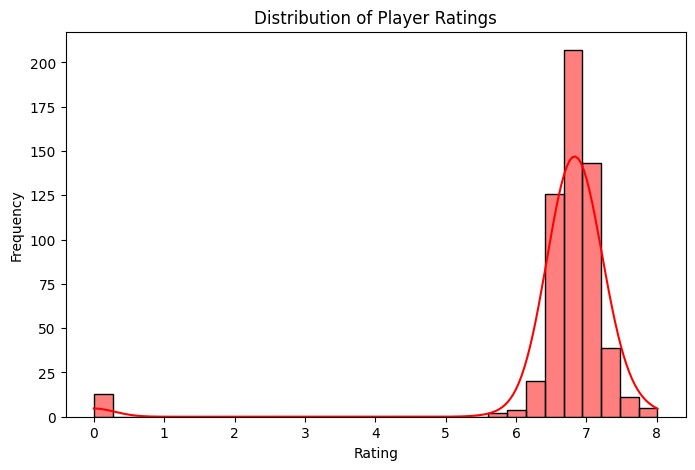

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

plt.figure(figsize=(8, 5))
sns.histplot(df['rating'], bins=30, kde=True, color='red')
plt.title('Distribution of Player Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

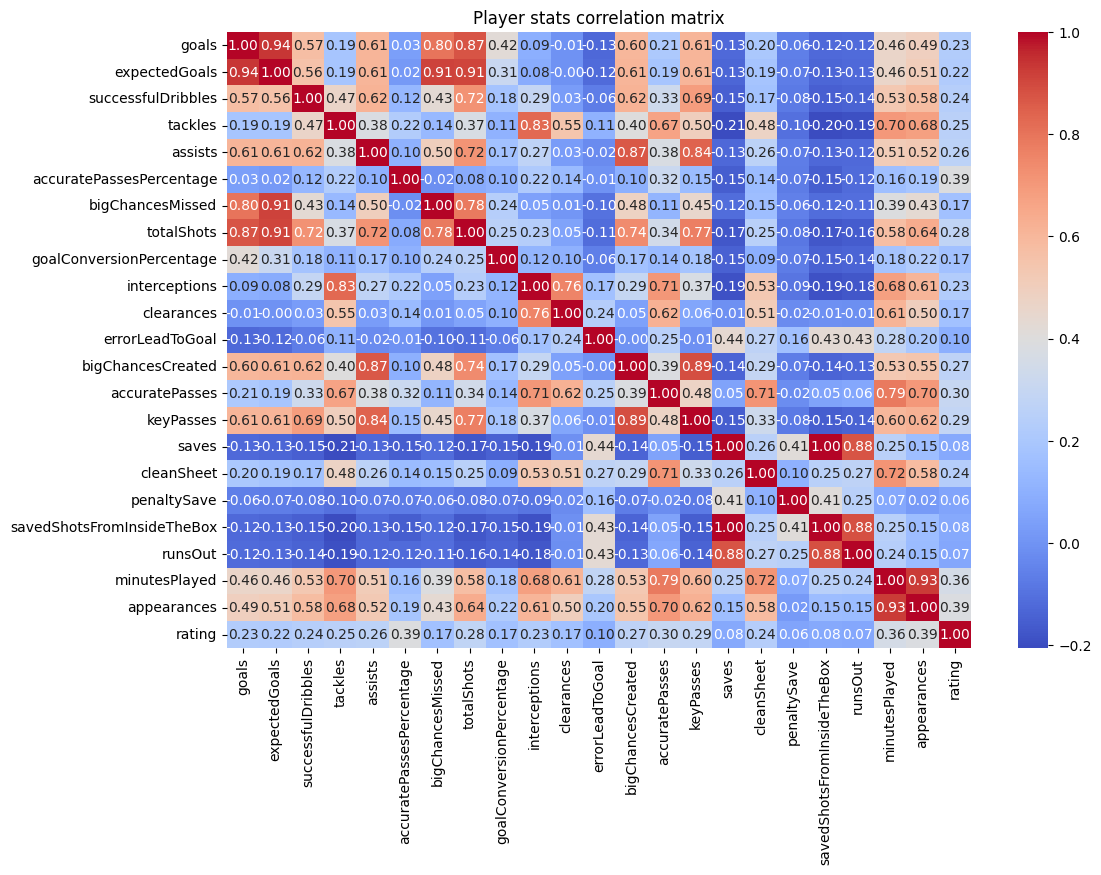

In [4]:
numeric_df = cleaned_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Player stats correlation matrix')
plt.show()

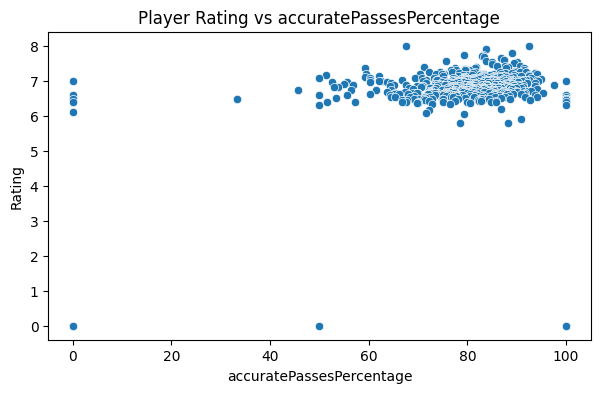

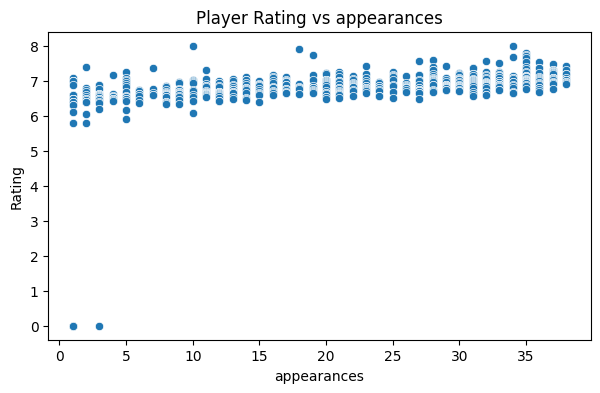

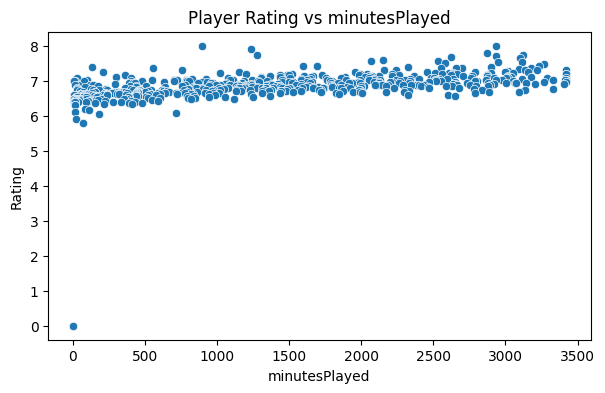

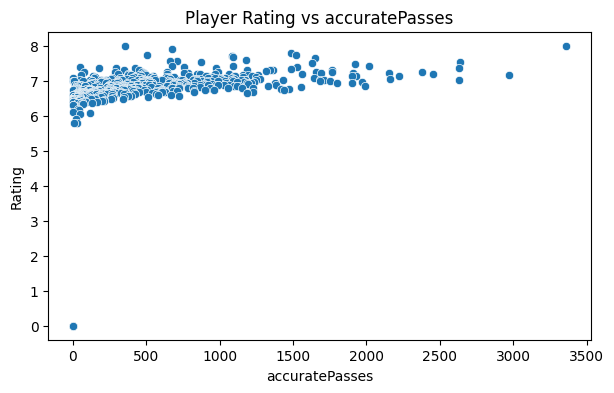

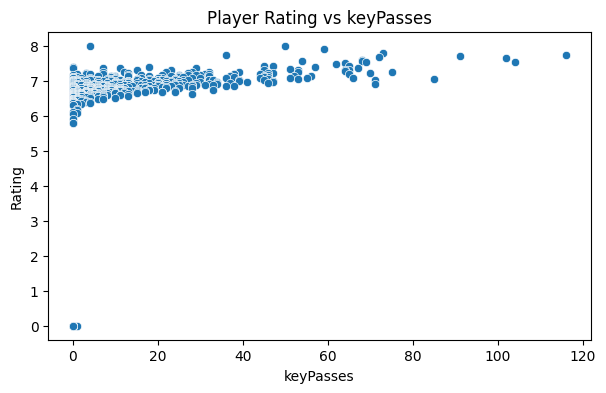

In [5]:
corr = correlation_matrix['rating'].drop('rating').abs().sort_values(ascending=False).head(5)
for feature in corr.index:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(x=df[feature], y=df['rating'])
    plt.title(f'Player Rating vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Rating')
    plt.show()

In [6]:
X = numeric_df.drop('rating', axis=1)
y = numeric_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R2 Score: {r2:.4f}')

R2 Score: 0.4350


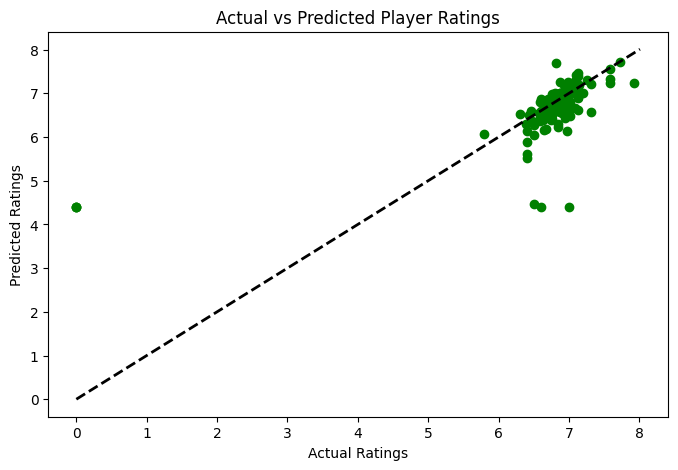

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='green')
plt.title('Actual vs Predicted Player Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

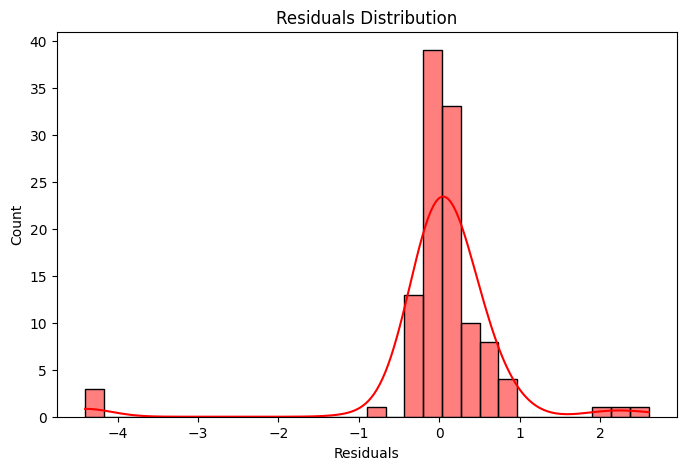

In [8]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='red')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()
